In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from skimage.measure import label,regionprops
from skimage.transform import resize
from PIL import Image
import cv2

In [2]:
#Load images and respective labels 
train_images = np.load('data/train_images.npy',encoding = 'latin1')
test_images = np.load('data/test_images.npy',encoding = 'latin1')
T_text = np.loadtxt('train_labels.csv', usecols=1, delimiter=',', dtype='str')

#Drop image indices and format image dimensions
train_images = train_images[:,1]
X = np.zeros((10000,10000))
for i in range(10000) : 
    X[i] = np.array(train_images[i]) 
X = X.reshape(10000,100, 100)

test_images = test_images[:,1]
X_test = np.zeros((10000,10000))
for i in range(10000) : 
    X_test[i] = np.array(test_images[i])
X_test = X_test.reshape(10000, 100, 100)

#Create category dictionary of classes and numerical target vector
T_text = T_text[1:]
catSet = list(set(T_text))
numsToCats = {}
for i in range(31) : 
    numsToCats[i] = catSet[i]
catsToNums = dict((v,k) for k,v in numsToCats.items())
T_num = np.zeros((10000, 31))
for i in range(10000) : 
    ind = catsToNums [ T_text[i] ]
    T_num[i][ind] = 1
    
#We now have two dictionaries that allow us to swap between 
#numerical and text representations of class labels 

Category:  shovel


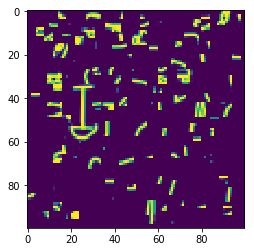

Category:  rifle


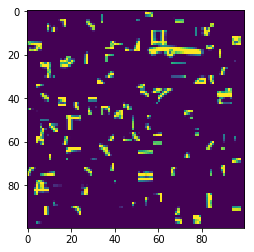

Category:  scorpion


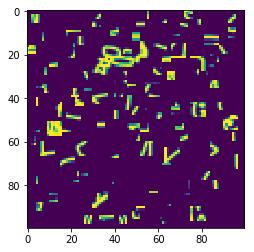

Category:  apple


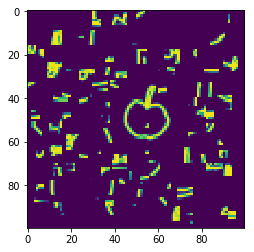

Category:  spoon


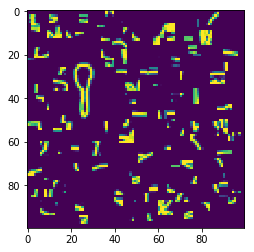

In [3]:
#Preview first 5 images with labels
for i in range(5) : 
    print('Category: ', T_text[i])
    plt.imshow(X[i])
    plt.show()

In [4]:
#Preliminary denoising of images with openCV
#This will allow us to more accurately extract objects using boundary boxes
#X_prelim = np.zeros((10000, 100, 100))
def denoise(X) : 
    X_prelim = np.zeros((len(X), 100, 100))
    for i in range(len(X)) : 
        img = X[i]
        new_p = Image.fromarray(img)
        if new_p.mode != 'RGB':
            new_p = new_p.convert('RGB')
        new_p = np.array(new_p)
        processed_p = cv2.fastNlMeansDenoisingColored(new_p,None,40,60,7,21)
        processed_p = cv2.cvtColor(processed_p, cv2.COLOR_BGR2GRAY)
        processed_p = processed_p.reshape(1,100,100)
        X_prelim[i] = processed_p
    return X_prelim

X_prelim = denoise(X)

Category:  shovel


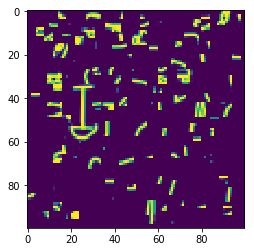

Category:  rifle


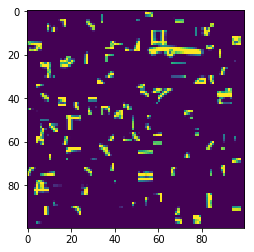

Category:  scorpion


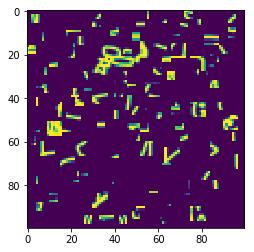

Category:  apple


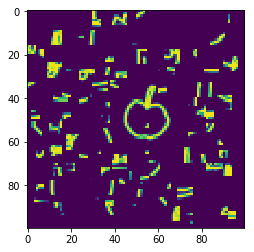

Category:  spoon


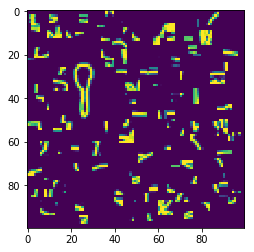

In [5]:
#preview same 5 images with labels after preliminary denoising
for i in range(5) : 
    print('Category: ', T_text[i])
    plt.imshow(X_prelim[i])
    plt.show()


Category:  shovel


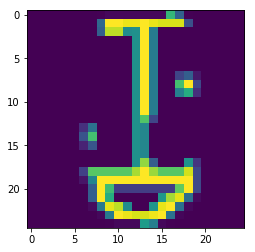

Category:  rifle


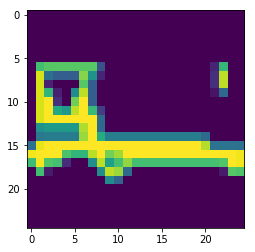

Category:  scorpion


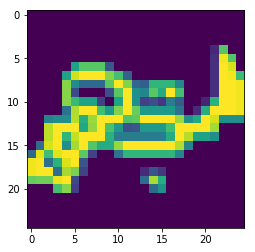

Category:  apple


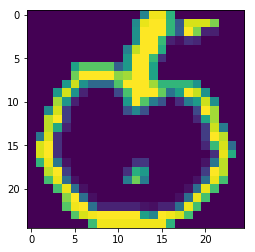

Category:  spoon


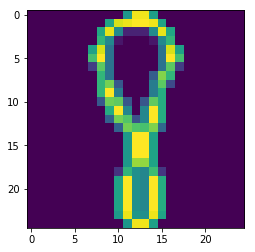

In [6]:
#Now the meat of our image preprocessing:
#First, we see that the objects in our images are brighter than most of the noise in the image
#We start by squashing weaker pixels to zero and raising the brightness of survivors
#Then, we extract the largest boundary box from each image, praying that it contains the obect of interest
#This relies on the assumption that the area with the largest pixel density will indeed be our object
#After analyzing the areas of the largest boundary boxes (and balancing the height/width)
#we see that the objects are almost all contained in a 25x25 pixel space, so we 
#resize appropriately so as to not lose image detail
newDims = 25
pixThresh = 100

def cleanImages(images) : 
    newX = np.zeros((len(images), newDims, newDims))
    interMed = np.zeros((len(images), 100, 100))
    for i in range(len(images)) : 
        #Remove weak pixels
        image = squashPixels(images[i])
        
        #Feature extraction: get location of image with highest pixel density
        boundary = boundaryExtraction(image)
        b0, b1, b2, b3 = boundary[0], boundary[1], boundary[2], boundary[3]
        height = b3 - b1
        width = b2 - b0
        area = height * width
        
        #Get euclidian center of boundary box
        centerHeight = (b3 + b1)//2
        centerWidth = (b2 + b0)//2
        
        #Balance height and width to avoid squishing image during resize
        if height > width : 
            dif = height - width
            width += dif 
        elif width > height :
            dif = width - height
            height += dif
        
        #print(width * height)
        
        #new dimensions for centered object
        b3_new = centerHeight + height//2
        b1_new = centerHeight - height//2
        b2_new = centerWidth + width//2
        b0_new = centerWidth - width//2
        
        #noise may be contained in the balanced image, 
        #so we copy pixels only from the bbox to clean image
        interMed[i][ b0 : b2, b1 : b3 ] = image[ b0 : b2, b1 : b3 ]
        
        #print(area)
        
        #if area returned is not large enough to contain an object, assume to be empty and leave blank
        if area > 120: 
            newImage = interMed[i][ b0_new : b2_new , b1_new : b3_new ]  
            if newImage.shape[0] == 0 or newImage.shape[1] == 0 : 
                continue 
            newX[i] = resize(newImage,(newDims,newDims), mode='constant')
    
    return newX

#reduce weak pixels to zero and maximize rest
def squashPixels(image) : 
    for i in range(100):
        for j in range(100):
                if image[i][j] > pixThresh : image[i][j] = 255
                else: image[i][j] = 0  
    return image 

#extract boundary boxes
def boundaryExtraction(image) : 
    labels = label(image, connectivity=1)
    regions = regionprops(labels, image)
    maxBoundary = []
    maxRegion = 0
    for i in range(len(regions)) :
        bounds = list( regions[i].bbox )
        height = bounds[3] - bounds[1]
        width = bounds[2] - bounds[0]
        area = height * width
        if area > maxRegion:
            maxRegion = area
            maxBoundary = bounds
    return maxBoundary

X_clean = cleanImages(X)

for i in range(0,5) : 
    test = cleanImages(X_prelim[i].reshape(1, 100,100))
    print('Category: ', T_text[i])
    plt.imshow(test.reshape(newDims,newDims))
    plt.show()

In [ ]:
#From the above we see that this preprocessing can be improved
#For the skateboard object, we see that noise was included in the boundary box returned with our obect
#This will lead to problems with classification
#Currently the most pressing issue in this task

In [ ]:
#SAVE
X_save = np.zeros((10000, newDims*newDims))
for i in range(len(X)) : 
    X_save[i] = X_train_C[i].reshape(newDims*newDims)
np.save('train_clean.npy', X_save)